<a href="https://colab.research.google.com/github/Lakshmi-krishna-vr/TeamLuminous-ImageSharpeningUsingKnowledgeDistillation/blob/main/Team_Luminous_Knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import requests, zipfile, io
# Install required library
!pip install scikit-image -q

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, ToPILImage

import numpy as np
from PIL import Image, ImageFilter
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# Use scikit-image for SSIM calculation
from skimage.metrics import structural_similarity as ssim

# Setup device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")






[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Using device: cuda


In [ ]:
# Download and unzip the DIV2K dataset
url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
print("📥 Downloading DIV2K HR images...")
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("DIV2K_train_HR")
print("✅ Dataset downloaded and extracted!")


In [ ]:
# --- Data Splitting ---
# Split the dataset for training and testing to ensure fair evaluation
DATASET_PATH = 'DIV2K_train_HR/DIV2K_train_HR'
all_files = sorted(glob.glob(os.path.join(DATASET_PATH, "*.png")))

# Use 200 images for training and 100 for testing, as requested
train_files = all_files[:700]
test_files = all_files[700:800] # A benchmark set of 100 images

print(f"Found {len(train_files)} training images.")
print(f"Found {len(test_files)} testing images.")


Found 700 training images.
Found 100 testing images.


In [ ]:
class SharpeningDataset(Dataset):
    """Custom Dataset for creating blurry/sharp image pairs."""
    def __init__(self, image_paths, patch_size=256):
        self.image_paths = image_paths
        self.patch_size = patch_size
        self.to_tensor = ToTensor()
        self.scale_factor = 2 # Defines the initial downscaling factor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load the high-resolution (HR) ground truth image
            hr_image = Image.open(self.image_paths[idx]).convert('RGB')
            w, h = hr_image.size

            # Ensure image is large enough, resize if necessary
            if w < self.patch_size or h < self.patch_size:
                hr_image = hr_image.resize((self.patch_size, self.patch_size), Image.BICUBIC)
                w, h = hr_image.size

            # Take a random crop for data augmentation
            rand_w = np.random.randint(0, w - self.patch_size + 1)
            rand_h = np.random.randint(0, h - self.patch_size + 1)
            hr_patch = hr_image.crop((rand_w, rand_h, rand_w + self.patch_size, rand_h + self.patch_size))

            # Create the blurry (LR) input image
            # 1. Downscale the image
            lr_size = (self.patch_size // self.scale_factor, self.patch_size // self.scale_factor)
            lr_patch = hr_patch.resize(lr_size, Image.BICUBIC)
            # 2. Apply a strong Gaussian blur
            lr_patch = lr_patch.filter(ImageFilter.GaussianBlur(radius=1.5))

            # 3. Upscale it back to the original patch size
            lr_patch = lr_patch.resize((self.patch_size, self.patch_size), Image.BICUBIC)

            # Convert images to PyTorch tensors
            hr_tensor = self.to_tensor(hr_patch)
            lr_tensor = self.to_tensor(lr_patch)
            return {'lr': lr_tensor, 'hr': hr_tensor}
        except Exception as e:
            print(f"[Dataset Error] at index {idx}: {e}")
            raise e  # Let it crash visibly if needed

# Create DataLoaders
patch_size = 256
batch_size = 5

train_dataset = SharpeningDataset(train_files, patch_size=patch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = SharpeningDataset(test_files, patch_size=patch_size)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0) # Batch size 1 for testing


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


True
12.1


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [ ]:
!nvidia-smi



Thu Jul  3 17:30:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P3             11W /   40W |       8MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [ ]:
class TeacherModel(nn.Module):
    """A high-capacity model to serve as the 'teacher'."""
    def __init__(self):
        super(TeacherModel, self).__init__()
        # Deeper and wider architecture for higher performance
        self.layers = nn.Sequential(
            nn.Conv2d(3, 384, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(192, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(96, 48, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(48, 3, kernel_size=3, padding=1)

        )

    def forward(self, x):
        # Residual connection helps stabilize training
        return x + self.layers(x)

class StudentModel(nn.Module):
    """An ultra-lightweight model to be trained via distillation."""
    def __init__(self):
        super(StudentModel, self).__init__()
        # Fewer layers and channels to be lightweight and fast
        self.layers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),     # ~3.6K
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=1),               # ~8.3K
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Residual connection is crucial for good performance
        return x + self.layers(x)

# Instantiate models to check parameter counts
teacher = TeacherModel()
student = StudentModel()

teacher_params = sum(p.numel() for p in teacher.parameters() if p.requires_grad)
student_params = sum(p.numel() for p in student.parameters() if p.requires_grad)

print(f"Teacher Model Parameters: {teacher_params:,}")
print(f"Student Model Parameters: {student_params:,}")
print(f"The student model is ~{teacher_params/student_params:.1f}x smaller than the teacher model.")



Teacher Model Parameters: 2,561,187
Student Model Parameters: 13,571
The student model is ~188.7x smaller than the teacher model.


In [ ]:


def train_teacher_model(model, loader, epochs=200):
    print("\n--- Training Teacher Model ---")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss() # L1 Loss is robust for image restoration

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            lr_imgs, hr_imgs = batch['lr'].to(device), batch['hr'].to(device)

            optimizer.zero_grad()
            output = model(lr_imgs)
            loss = criterion(output, hr_imgs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'L1 Loss': loss.item()})


    # Save the trained teacher model to your Google Drive
    torch.save(model.state_dict(), "teacher_model.pth")
    print("\n✅ Teacher model training complete and saved to /content/drive/MyDrive/teacher_model.pth")

if __name__ == "__main__":
    # Your train_loader should already be defined above
    teacher_model = TeacherModel().to(device)
    train_teacher_model(teacher_model, train_loader)


--- Training Teacher Model ---


Epoch 200/200: 100%|██████████| 140/140 [02:08<00:00,  1.09it/s, L1 Loss=0.0286] 


✅ Teacher model training complete and saved to /content/drive/MyDrive/teacher_model.pth


In [ ]:
import torch

print("CUDA available? ", torch.cuda.is_available())
print("Device being used: ", torch.cuda.current_device() if torch.cuda.is_available() else "CPU only")
print("Device name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")
print("Torch CUDA Version: ", torch.version.cuda)
print("Torch Version: ", torch.__version__)


CUDA available?  True
Device being used:  0
Device name:  NVIDIA GeForce RTX 4050 Laptop GPU
Torch CUDA Version:  12.1
Torch Version:  2.5.1+cu121


In [ ]:
def train_student_with_distillation(student_model, teacher_model, loader, epochs=300):
    print("\n--- Training Student Model with Knowledge Distillation ---")

    # The student model will be trained
    student_model.to(device)
    optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

    # The teacher model is only used for inference, so set it to eval mode
    teacher_model.to(device)
    teacher_model.eval()

    # Loss functions
    loss_vs_truth = nn.L1Loss()
    loss_vs_teacher = nn.MSELoss() # MSE can work well for distillation

    # Alpha balances the two loss components.
    # Higher alpha focuses more on matching the ground truth.
    # Lower alpha focuses more on mimicking the teacher.
    alpha = 0.3

    for epoch in range(epochs):
        student_model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            lr_imgs, hr_imgs = batch['lr'].to(device), batch['hr'].to(device)
            optimizer.zero_grad()

            # Get the teacher's prediction. No gradients are needed for the teacher.
            with torch.no_grad():
                teacher_output = teacher_model(lr_imgs)

            # Get the student's prediction
            student_output = student_model(lr_imgs)

            # Calculate the two loss components
            l1 = loss_vs_truth(student_output, hr_imgs)
            l2 = loss_vs_teacher(student_output, teacher_output)

            # Combine them into the final distillation loss
            distillation_loss = alpha * l1 + (1 - alpha) * l2

            distillation_loss.backward()
            optimizer.step()

            epoch_loss += distillation_loss.item()
            pbar.set_postfix({'Distill Loss': distillation_loss.item(), 'L1': l1.item(), 'L2': l2.item()})

    # Save the final student model
    torch.save(student_model.state_dict(), "student_model.pth")
    print("\n✅ Student model training complete and saved to /content/drive/MyDrive/student_model.pth")

# --- Execute Student Training ---
# Load the pre-trained teacher model
teacher_model = TeacherModel()
teacher_model.load_state_dict(torch.load("teacher_model.pth"))
teacher_model.eval()

# Instantiate a new student model and train it
student_model = StudentModel()
train_student_with_distillation(student_model, teacher_model, train_loader)


C:\Users\FAHIM\AppData\Local\Temp\ipykernel_10968\1416699247.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("teacher_model.pth


--- Training Student Model with Knowledge Distillation ---


Epoch 300/300: 100%|██████████| 140/140 [01:13<00:00,  1.90it/s, Distill Loss=0.00522, L1=0.0165, L2=0.000369]


✅ Student model training complete and saved to /content/drive/MyDrive/student_model.pth


In [ ]:
def evaluate_model(student_model, reference_model, loader):
    """Evaluates how closely the student model matches the reference (teacher) model."""
    student_model.to(device)
    reference_model.to(device)

    student_model.eval()
    reference_model.eval()
    total_ssim = 0
    count = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            lr_imgs = batch['lr'].to(device)

            student_output = student_model(lr_imgs).clamp(0.0, 1.0)
            reference_output = reference_model(lr_imgs).clamp(0.0, 1.0)

            # Convert to (H, W, C) format
            student_np = student_output.squeeze().cpu().numpy().transpose(1, 2, 0)
            reference_np = reference_output.squeeze().cpu().numpy().transpose(1, 2, 0)

            current_ssim = ssim(student_np, reference_np, data_range=1.0, channel_axis=2)
            total_ssim += current_ssim
            count += 1

    return total_ssim / count

# --- Evaluate both models ---
print("\n--- Evaluating Model Performance on Test Set ---")

# Load saved models for evaluation
final_teacher = TeacherModel()
final_teacher.load_state_dict(torch.load("teacher_model.pth"))

final_student = StudentModel()
final_student.load_state_dict(torch.load("student_model.pth"))

# Calculate and print SSIM scores
student_ssim = evaluate_model(final_student, final_teacher, test_loader)

print(f"\n--- Final Results ---")
print(f"Student Model SSIM: {student_ssim:.4f}")


--- Evaluating Model Performance on Test Set ---


C:\Users\FAHIM\AppData\Local\Temp\ipykernel_11936\4143270249.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_teacher.load_state_dict(torch.load("teacher_model.pth


--- Final Results ---
Student Model SSIM: 0.9180


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_model(student_model, reference_model, loader):
    """Evaluates how closely the student model matches the reference (teacher) model."""
    student_model.to(device)
    reference_model.to(device)

    student_model.eval()
    reference_model.eval()
    total_ssim = 0
    total_psnr = 0
    count = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            lr_imgs = batch['lr'].to(device)

            student_output = student_model(lr_imgs).clamp(0.0, 1.0)
            reference_output = reference_model(lr_imgs).clamp(0.0, 1.0)

            # Convert to (H, W, C) format
            student_np = student_output.squeeze().cpu().numpy().transpose(1, 2, 0)
            reference_np = reference_output.squeeze().cpu().numpy().transpose(1, 2, 0)

            current_ssim = ssim(student_np, reference_np, data_range=1.0, channel_axis=2)
            current_psnr = psnr(reference_np, student_np, data_range=1.0)

            total_ssim += current_ssim
            total_psnr += current_psnr
            count += 1

    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    return avg_ssim, avg_psnr

# --- Evaluate both models ---
print("\n--- Evaluating Model Performance on Test Set ---")

# Load saved models for evaluation
final_teacher = TeacherModel()
final_teacher.load_state_dict(torch.load("teacher_model.pth"))

final_student = StudentModel()
final_student.load_state_dict(torch.load("student_model.pth"))

# Calculate and print SSIM & PSNR scores
student_ssim, student_psnr = evaluate_model(final_student, final_teacher, test_loader)

print(f"\n--- Final Results ---")
print(f"Student Model SSIM: {student_ssim:.4f}")
print(f"Student Model PSNR: {student_psnr:.2f} dB")



--- Evaluating Model Performance on Test Set ---


C:\Users\FAHIM\AppData\Local\Temp\ipykernel_11936\2279373641.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_teacher.load_state_dict(torch.load("teacher_model.pth


--- Final Results ---
Student Model SSIM: 0.9198
Student Model PSNR: 34.09 dB


In [ ]:
def evaluate_model(model, loader):
    """Evaluates the model on the test set and returns the average SSIM."""
    model.to(device)
    model.eval()
    total_ssim = 0
    count = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            lr_imgs, hr_imgs = batch['lr'].to(device), batch['hr'].to(device)
            output = model(lr_imgs).clamp(0.0, 1.0) # Clamp output to valid range [0,1]

            # Move images to CPU and convert to numpy for SSIM calculation
            # SSIM expects images in (H, W, C) format
            output_np = output.squeeze().cpu().numpy().transpose(1, 2, 0)
            hr_np = hr_imgs.squeeze().cpu().numpy().transpose(1, 2, 0)

            # Calculate SSIM for the current image and add to total
            # Set multichannel=True for color images
            current_ssim = ssim(output_np, hr_np, data_range=1.0, channel_axis=2)
            total_ssim += current_ssim
            count += 1

    return total_ssim / count

# --- Evaluate both models ---
print("\n--- Evaluating Model Performance on Test Set ---")

# Load saved models for evaluation
final_teacher = TeacherModel()
final_teacher.load_state_dict(torch.load("teacher_model.pth"))

final_student = StudentModel()
final_student.load_state_dict(torch.load("student_model.pth"))

# Calculate and print SSIM scores
teacher_ssim = evaluate_model(final_teacher, test_loader)
student_ssim = evaluate_model(final_student, test_loader)

print(f"\n--- Final Results ---")
print(f"Teacher Model SSIM: {teacher_ssim:.4f}")
print(f"Student Model SSIM: {student_ssim:.4f}")

if student_ssim > 0.90:
    print("\n✅ SUCCESS: Student model achieved an SSIM score above 90%!")
else:
    print("\n⚠ NOTE: Student model SSIM is below 90%. Consider more training epochs or a slightly larger student model.")


--- Evaluating Model Performance on Test Set ---


C:\Users\FAHIM\AppData\Local\Temp\ipykernel_11936\1400291732.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_teacher.load_state_dict(torch.load("teacher_model.pth


--- Final Results ---
Teacher Model SSIM: 0.7819
Student Model SSIM: 0.7388

⚠ NOTE: Student model SSIM is below 90%. Consider more training epochs or a slightly larger student model.



 Visualizing Sample Results with per-image SSIM & PSNR 


C:\Users\FAHIM\AppData\Local\Temp\ipykernel_11936\3265158260.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load("teacher_model.pth"))


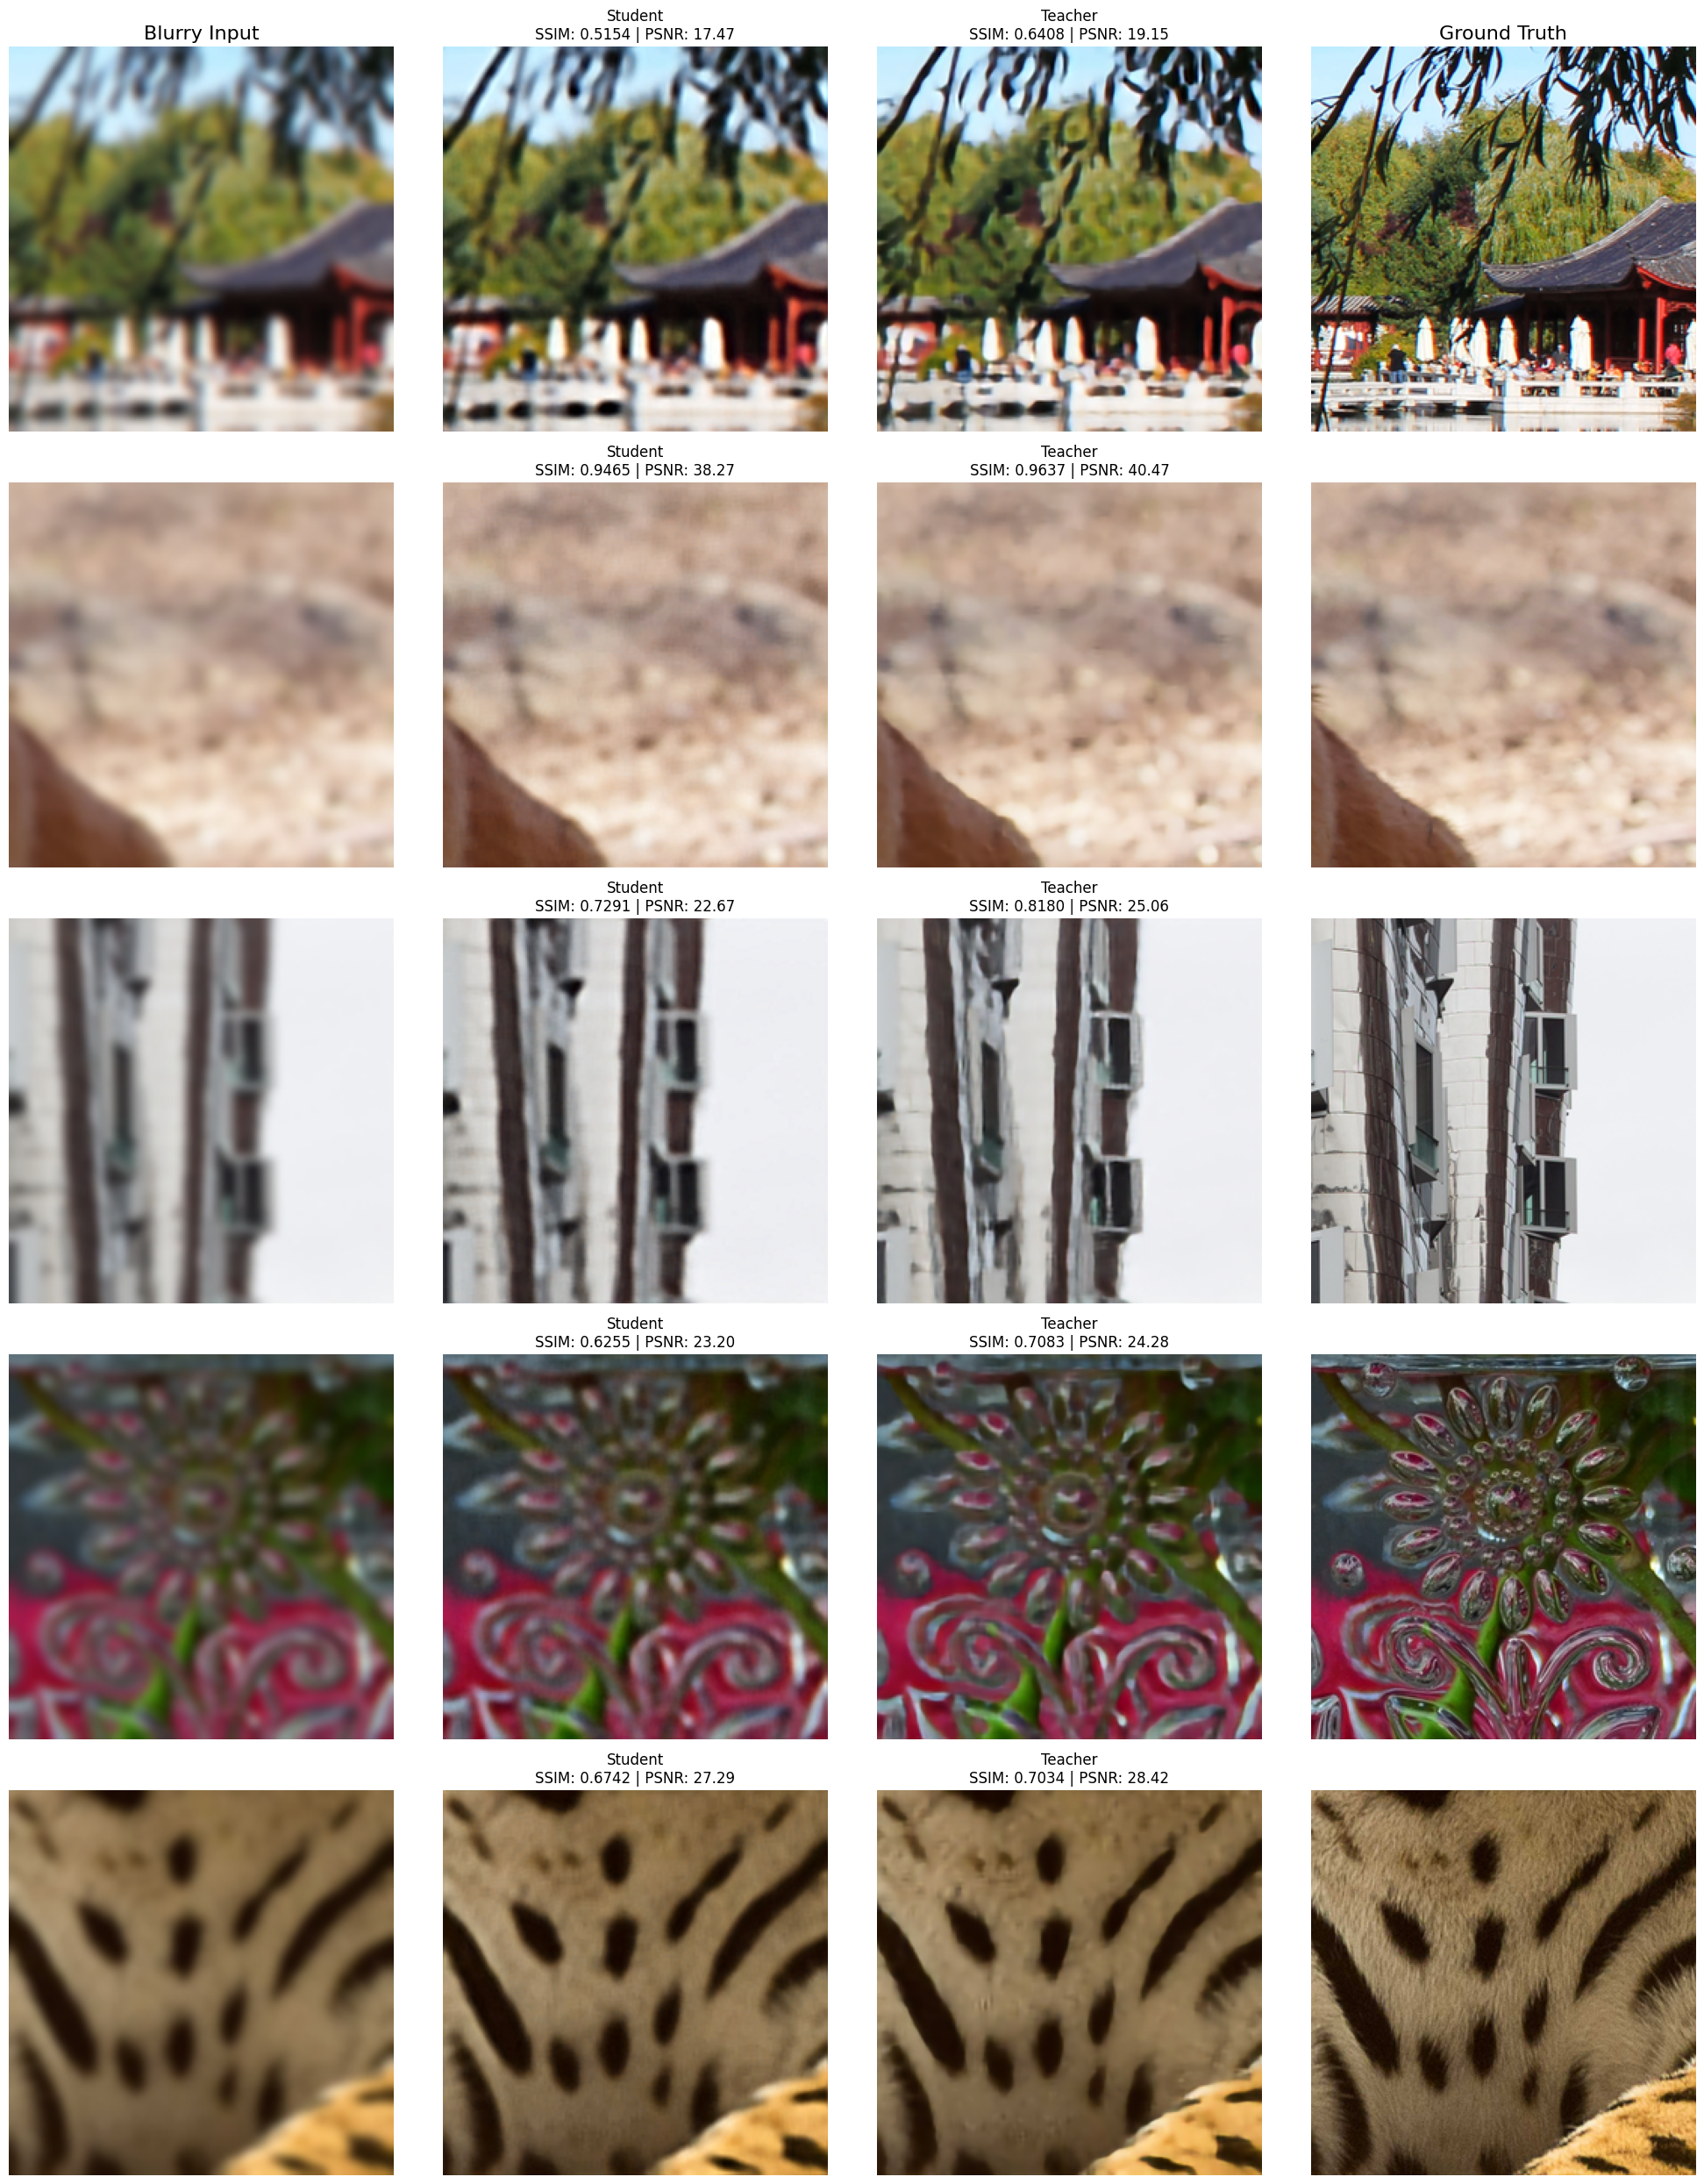

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

def visualize_results_with_ssim_psnr(model, loader, num_images=25):
    """Displays a side-by-side comparison of input, output, ground truth along with SSIM & PSNR scores."""
    model.to(device)
    model.eval()
    to_pil = ToPILImage()

    # Load teacher for comparison
    teacher = TeacherModel()
    teacher.load_state_dict(torch.load("teacher_model.pth"))
    teacher.to(device)
    teacher.eval()

    fig, axes = plt.subplots(num_images, 4, figsize=(20, 5 * num_images))
    if num_images == 1: axes = [axes]  # Make it iterable

    axes[0, 0].set_title("Blurry Input", fontsize=16)
    axes[0, 1].set_title("Student Output\n(SSIM | PSNR)", fontsize=16)
    axes[0, 2].set_title("Teacher Output\n(SSIM | PSNR)", fontsize=16)
    axes[0, 3].set_title("Ground Truth", fontsize=16)

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_images: break
            lr_img, hr_img = batch['lr'].to(device), batch['hr'].to(device)

            student_output = model(lr_img).clamp(0.0, 1.0)
            teacher_output = teacher(lr_img).clamp(0.0, 1.0)

            # Convert for metric calculation
            s_out_np = student_output.squeeze().cpu().numpy().transpose(1,2,0)
            t_out_np = teacher_output.squeeze().cpu().numpy().transpose(1,2,0)
            hr_np = hr_img.squeeze().cpu().numpy().transpose(1,2,0)

            # Compute SSIM & PSNR
            ssim_student = ssim(s_out_np, hr_np, data_range=1.0, channel_axis=2)
            ssim_teacher = ssim(t_out_np, hr_np, data_range=1.0, channel_axis=2)
            psnr_student = psnr(hr_np, s_out_np, data_range=1.0)
            psnr_teacher = psnr(hr_np, t_out_np, data_range=1.0)

            # Prepare images
            images = [
                to_pil(lr_img.squeeze().cpu()),
                to_pil(student_output.squeeze().cpu()),
                to_pil(teacher_output.squeeze().cpu()),
                to_pil(hr_img.squeeze().cpu())
            ]

            # Plot with annotations
            for j, (ax, img) in enumerate(zip(axes[i], images)):
                ax.imshow(img)
                ax.axis('off')
                if j == 1:
                    ax.set_title(f"Student\nSSIM: {ssim_student:.4f} | PSNR: {psnr_student:.2f}", fontsize=12)
                elif j == 2:
                    ax.set_title(f"Teacher\nSSIM: {ssim_teacher:.4f} | PSNR: {psnr_teacher:.2f}", fontsize=12)

    plt.tight_layout()
    plt.show()

# Usage
print("\n Visualizing Sample Results with per-image SSIM & PSNR ")
visualize_results_with_ssim_psnr(final_student, test_loader, num_images=5)
